# Estonians on the r/place Canvas
data science project by Johan Erik Pukk, Jaanus Raudsik & Tanel Marran

Steps needed to complete:
1. Read in the data from *tile_placements_sorted.csv*
2. Try to identify the users who built the estonian flag and heart.
3. Map the contributions of the users identified in the previous task on the rest of the canvas
4. Create a heatmap of the contributions of the identified users
5. Identify regions and objects where the identified users contributed to
6. Making an informative and attractive poster about our findings from data

**<font color='red'>PS!<font>** The *tile_placements_sorted.csv* file is too large to commit to github. You'll need to download it into your local repository on your own.<br>
Link to dataset: http://skeeto.s3.amazonaws.com/share/tile_placements_sorted.csv.xz

### Helpful info
Reddit post about the r/place datasets: https://www.reddit.com/r/redditdata/comments/6640ru/place_datasets_april_fools_2017/

Here is a list of all Estonian structures that we have found on the canvas, with appropriated coordinates.
It may be beneficial to also add timesstamps, so we know when these structures existed.
The coordinates may not be super precise, so keep that in mind. These coords are simply for finding the ge

**Estonian Flag**<br>
Coordinates: (156, 70)
![title](Images/flag_156_70.png)

**Estonian Heart**<br>
Coordinates: (187, 118)
![title](Images/heart_187_118.png)

## Step 1
Import some libraries and read in the dataset. Create a dictionary for colors.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.ticker as mtick
import math
import seaborn as sb

In [2]:
raw_data = pd.read_csv("tile_placements_sorted.csv")
raw_data["x"] = raw_data["x_coordinate"]
raw_data["y"] = raw_data["y_coordinate"]
del raw_data["x_coordinate"]
del raw_data["y_coordinate"]

In [3]:
raw_data.sort_values("ts",ascending=False)

,ts,user,color,x,y
8951761,1491238734000,WcPEECDEtqTri0VN5AJggUWOi/A=,5,605,160
15110795,1491238733000,uLIYXambhhJnq+XQsp3/v4hOSg8=,3,31,16
1788175,1491238733000,4tD092krB0kr/mIgPzbkdWRbbuA=,15,159,602
10357844,1491238733000,c34iVZhk/TWfZvgLERa92dv4nXI=,10,33,70
776850,1491238733000,0zJQ/whk/woFFZpfA53DCstaOV8=,5,176,159
...,...,...,...,...,...
4776829,1490919349000,GP2B74SRyrZ3HIflSFoAzM+jS3U=,11,477,495
4776825,1490919337000,GP2B74SRyrZ3HIflSFoAzM+jS3U=,11,474,495
1256304,1490918781000,2puPLvQ6X2zTSpfBkHXhxlIVo40=,0,518,498
1256296,1490918728000,2puPLvQ6X2zTSpfBkHXhxlIVo40=,1,490,504


In [4]:
earliest = 1490979600000
latest = raw_data.ts.max()
print("Earliest timestamp:", earliest)
print("Latest timestamp:",latest)

Earliest timestamp: 1490979600000
Latest timestamp: 1491238734000


Notice that the colors in this dataset have numeric identifiers and thus we don't really know what number corresbonds to what color.

In [5]:
print("Total number of colors:", len(raw_data.color.value_counts()))

Total number of colors: 16


An array of color strings should be created where the index of the color in the array corresbonds to its identifier in the dataset.
Thankfully these colors are documented on the reddit post linked earlier.

In [6]:
colors = np.array(["FFFFFF","E4E4E4","888888","222222",
                   "FFA7D1","E50000","E59500","A06A42",
                   "E5D900","94E044","02BE01","00E5F0",
                   "0083C7","0000EA","E04AFF","820080"])

colordict = np.arange(3*16).reshape(16,3).astype(float)
for j in range(len(colors)):
    new = tuple(int(colors[j][i:i+2], 16)/255 for i in (0, 2, 4))
    colordict[j] = new
colordict

array([[1.        , 1.        , 1.        ],
       [0.89411765, 0.89411765, 0.89411765],
       [0.53333333, 0.53333333, 0.53333333],
       [0.13333333, 0.13333333, 0.13333333],
       [1.        , 0.65490196, 0.81960784],
       [0.89803922, 0.        , 0.        ],
       [0.89803922, 0.58431373, 0.        ],
       [0.62745098, 0.41568627, 0.25882353],
       [0.89803922, 0.85098039, 0.        ],
       [0.58039216, 0.87843137, 0.26666667],
       [0.00784314, 0.74509804, 0.00392157],
       [0.        , 0.89803922, 0.94117647],
       [0.        , 0.51372549, 0.78039216],
       [0.        , 0.        , 0.91764706],
       [0.87843137, 0.29019608, 1.        ],
       [0.50980392, 0.        , 0.50196078]])

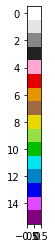

In [7]:
matrix = np.zeros((len(colordict),1,3))
for i in range(len(colordict)):
    matrix[i,0] = colordict[i]
imgplot = plt.imshow(matrix)

## Step 2
We need to create some reusable functions:
1. A method for displaying a part of a canvas, or at least form the data in a way that can be later displayed.
2. Find all instances where the coords are in some defined shape.
3. An ordered list of all pixels placed by a certain user.
4. Filter out every instances where the pixel wasn't of an appropriate color. 

First we'll create a method that takes in some canvas coords and a timestamp and returns a numpy array that can be used to print that canvas part on a plot.

##### Method to convert time into range 0-1 for ease of use.

In [8]:
def convert_time(percent): #converst range [0,1] to [1490918688000,1491238734000]
    return round((latest-earliest)*percent)+earliest

##### Method to get sections of canvas during specified time.

In [9]:
def canvas_region(x1,y1,x2,y2,time): # function 1
    width = x2-x1+1
    height = y2-y1+1
    time = convert_time(time)
    matrix = np.zeros((height,width,3))
    trimmed_data = raw_data[(raw_data.x >= x1) & (raw_data.x <= x2) & (raw_data.y >= y1) & (raw_data.y <= y2) & (raw_data.ts <= time)].sort_values('ts',ascending=True)
    for index, row in trimmed_data.iterrows():
        matrix[row.y-y1,row.x-x1] = colordict[row.color]
    return matrix

##### Method to find  which points were used in section of canvas during specific time

In [10]:
def instaces_in_region(x1,y1,x2,y2,starttime,endtime): # function 2
    starttime = convert_time(starttime)
    endtime = convert_time(endtime)
    return raw_data[(raw_data.x >= x1) & (raw_data.x <= x2) & (raw_data.y >= y1) & (raw_data.y <= y2) & (raw_data.ts <= endtime) & (raw_data.ts >= starttime)].sort_values('ts',ascending=True)

##### Method which finds pixels by users.

In [11]:
def user_points(userhash): #function 3
    return raw_data[(raw_data.user == userhash)]

##### Color filter

In [12]:
def color_filter(data,color_array): #function 4
    return data[(data.color.isin(color_array))]

##### Method to create neccessary plots for analyzing changes

In [13]:
def display_scatter(data, i):
    plt.figure(figsize=(15,15))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.scatter(data.x, data.y, c=colordict[data.color],marker='s', s=1, alpha=1)
    plt.xlim((0, 1000))
    plt.ylim((0, 1000))
    plt.xticks(np.arange(0,1000,50))
    plt.yticks(np.arange(0,1000,50))
    plt.tick_params(labeltop=True, labelright=True)
    plt.title('After '+str((i+0.1)*100)+'%')
    plt.gca().invert_yaxis()
    #plt.savefig(str(round(i, 1))+'.png')
    plt.show()

In [14]:
def display_scatter_decorated(data, i):
    plt.figure(figsize=(15,15))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.scatter(data.x, data.y, c='k',marker='s', s=1, alpha=1)
    plt.xlim((0, 1000))
    plt.ylim((0, 1000))
    plt.xticks(np.arange(0,1000,50))
    plt.yticks(np.arange(0,1000,50))
    plt.tick_params(labeltop=True, labelright=True)
    plt.title('After '+str((i+0.1)*100)+'%')
    plt.gca().invert_yaxis()
    #plt.savefig(str(round(i, 1))+'.png')
    plt.show()

##### Here is process of Estonian flag after each 10% of time.

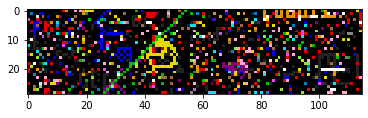

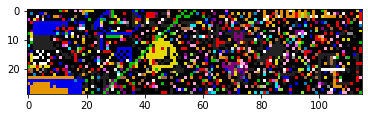

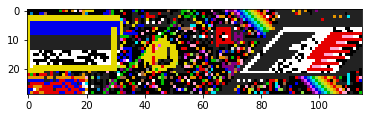

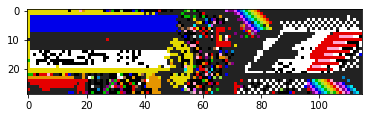

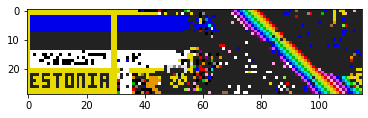

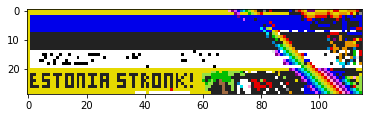

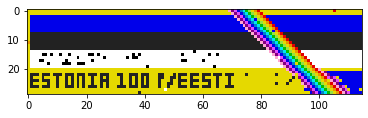

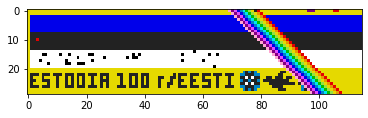

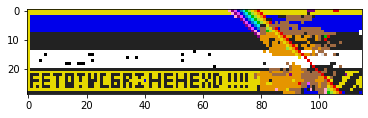

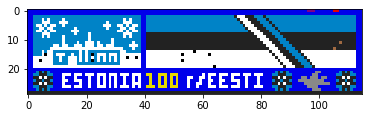

In [15]:
for time in np.arange(0.1, 1.1, 0.1):
    img = canvas_region(281,619,395,647,time)
    plt.figure()
    imgplot = plt.imshow(img)

## Step 3 ##

Now let's find some Estonians...

..from the flag.

##### Methods which finds which users helped to built the region we specified (estonian flag) and finds pixels made by those users.

In [16]:
def find_flag_builders(start_time, end_time):
    flag = instaces_in_region(282,621,354,638,start_time,end_time)
    flag = color_filter(flag,[0,12,13])
    vc = flag.user.value_counts()
    builders = vc[vc > 2].index
    return builders

def find_userset_points(users, t1, t2):
    t1 = convert_time(t1)
    t2 = convert_time(t2)
    return (raw_data[(raw_data.user.isin(users)) & (raw_data.ts >= t1) & (raw_data.ts <= t2)])
builders = find_flag_builders(0.1,0.8)
print("Total flag builders (identified estonians) " + str(len(builders)))
print("Pixels created by builders " + str(len(find_userset_points(builders,0,1))))

Total flag builders (identified estonians) 334
Pixels created by builders 28886


##### Method which plots activity chart.

In [17]:
def plot_activity(arr):
    df = pd.DataFrame(arr)
    ax = df.plot()
    ax.get_legend().remove()
    plt.ylabel("Pixels placed")
    plt.xlabel("Percentage of duration")
    ax.xaxis.set_major_formatter(mtick.FixedFormatter(['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']))
    plt.savefig('images/activity.png')
    plt.show()

##### Canvas halfway through timelapse

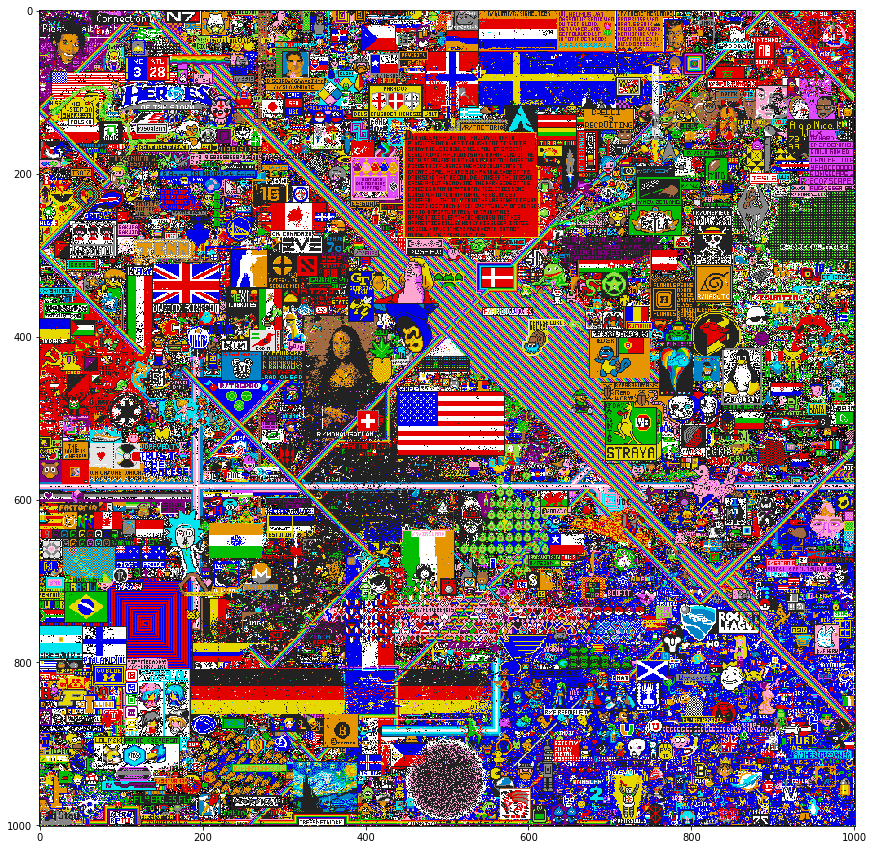

In [18]:
img = canvas_region(0,0,1000,1000,0.5)
plt.figure(figsize=(15,15))
imgplot = plt.imshow(img)
#plt.savefig('images/50precent.png')

Here we're going to generate loads of scatter plots with a step of 7.2 hours (10% of the entire canvas lifetime) per plot. These will show us what the Estonians did in each timeframe it'll help us find structures that the Estonians contributed to.

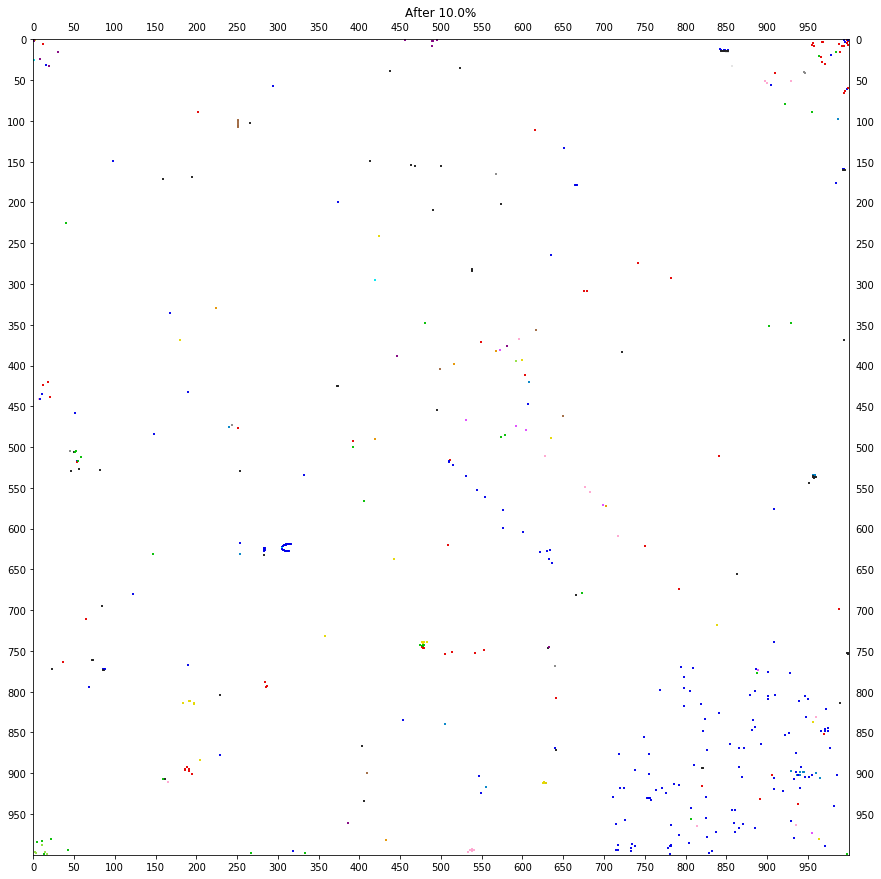

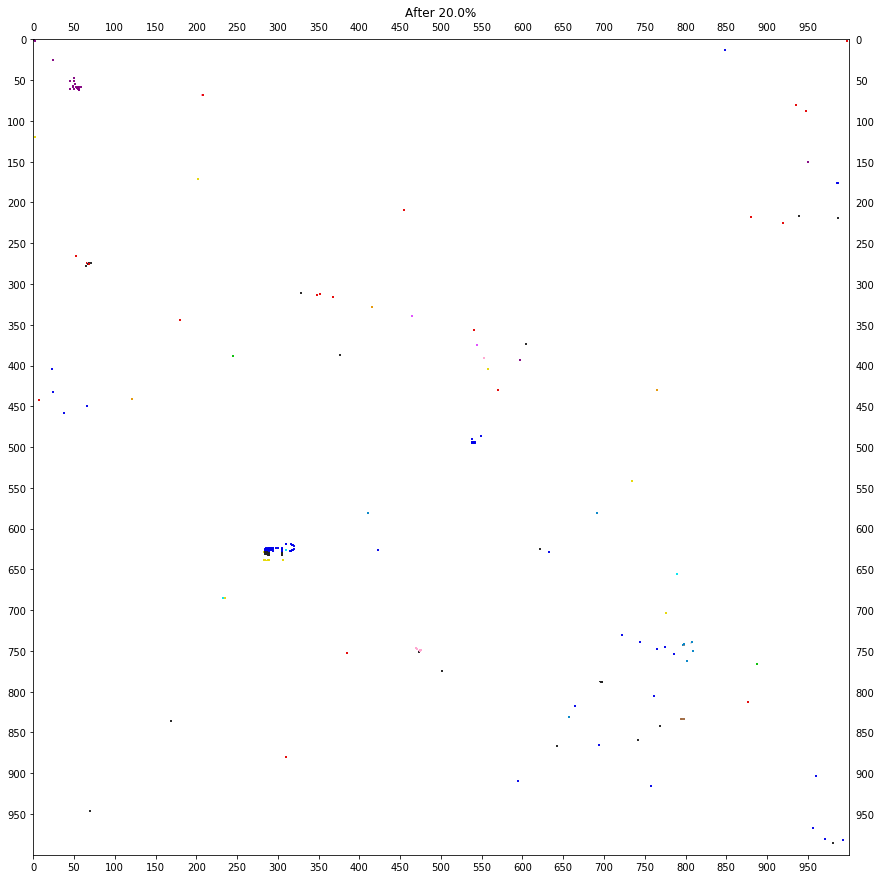

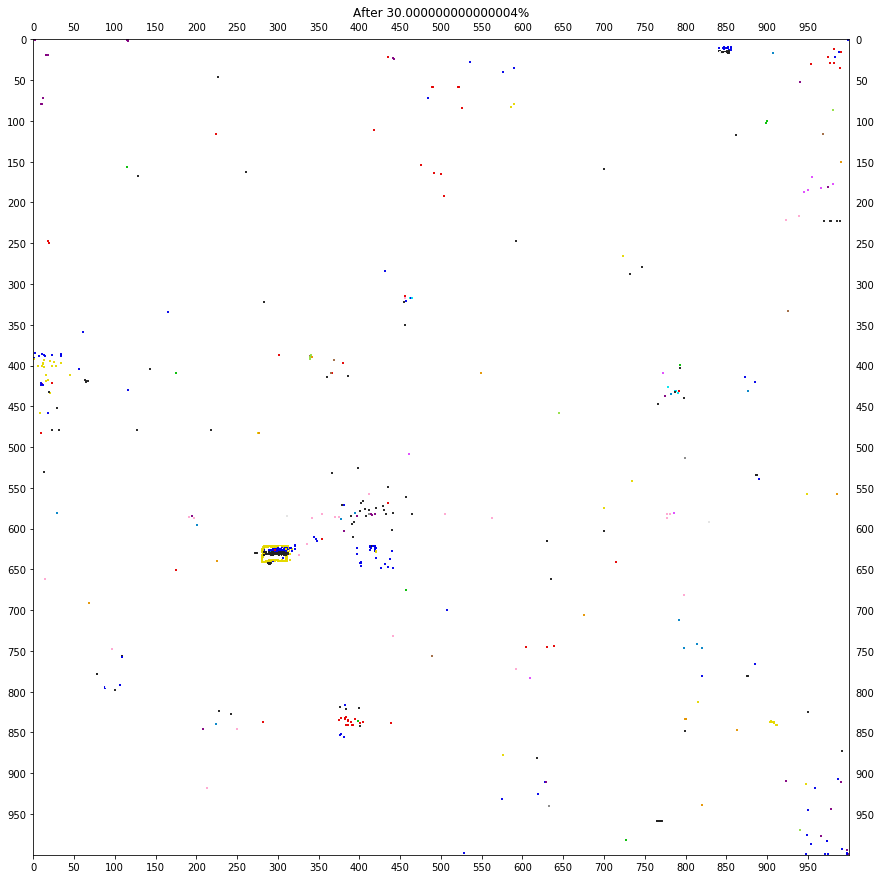

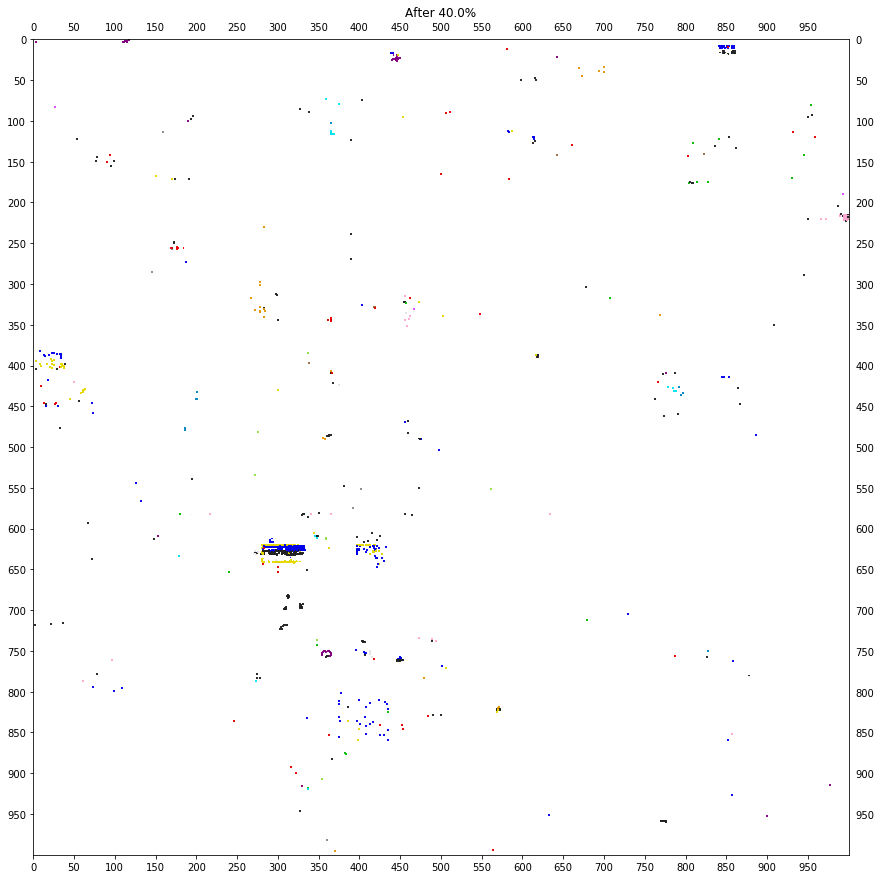

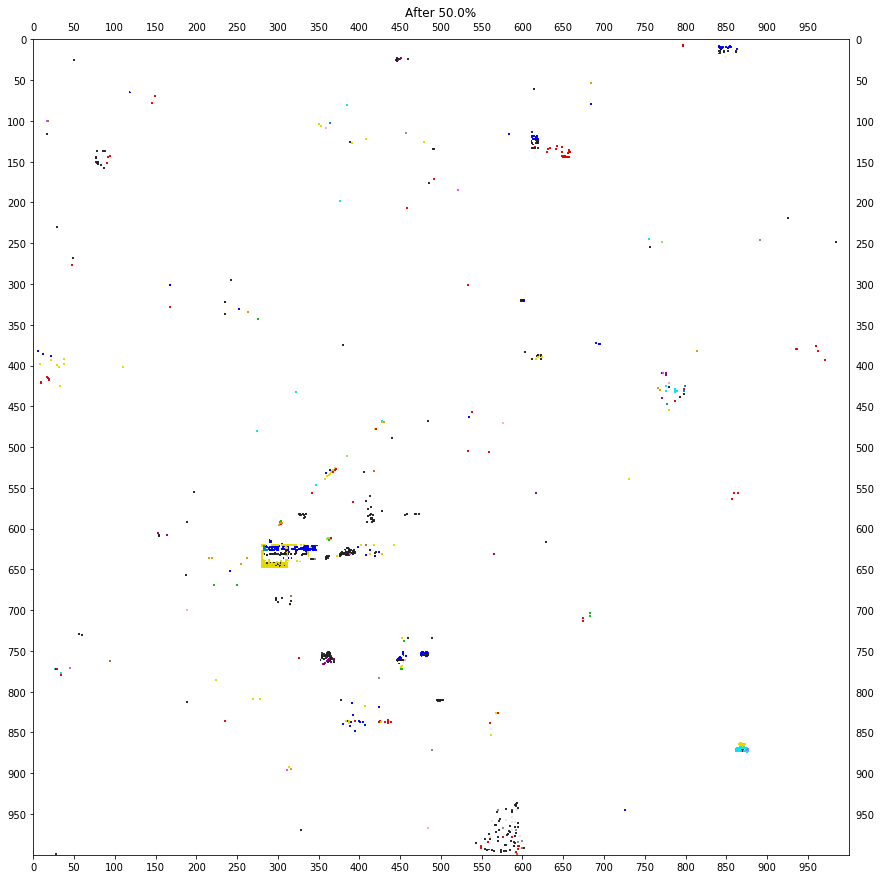

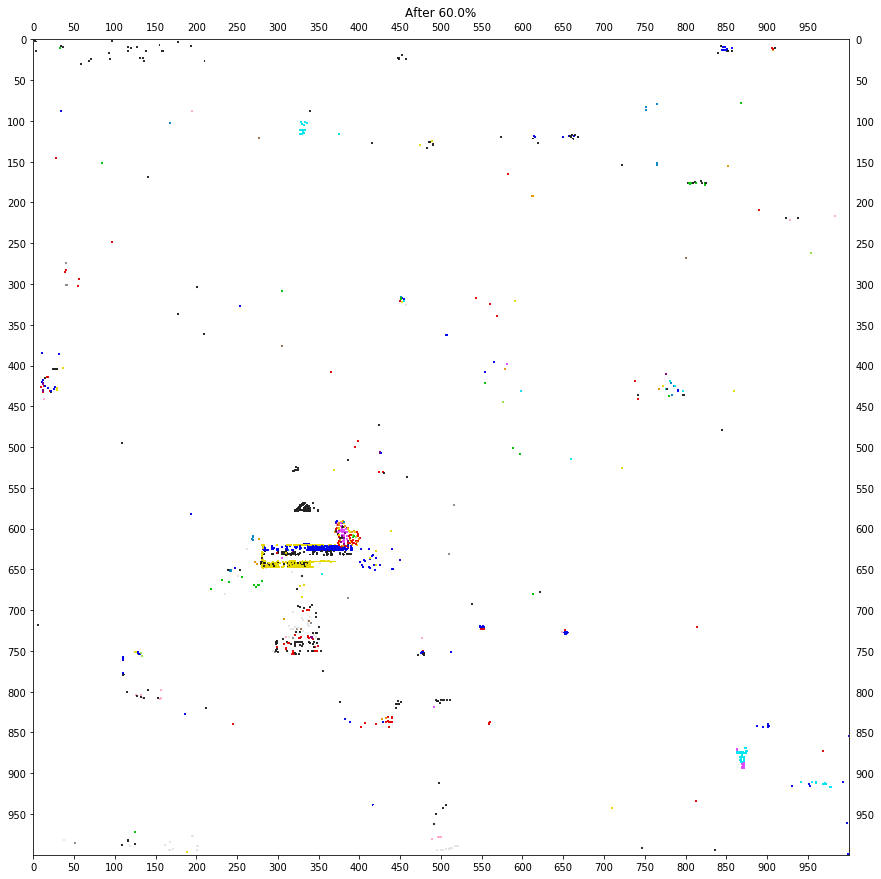

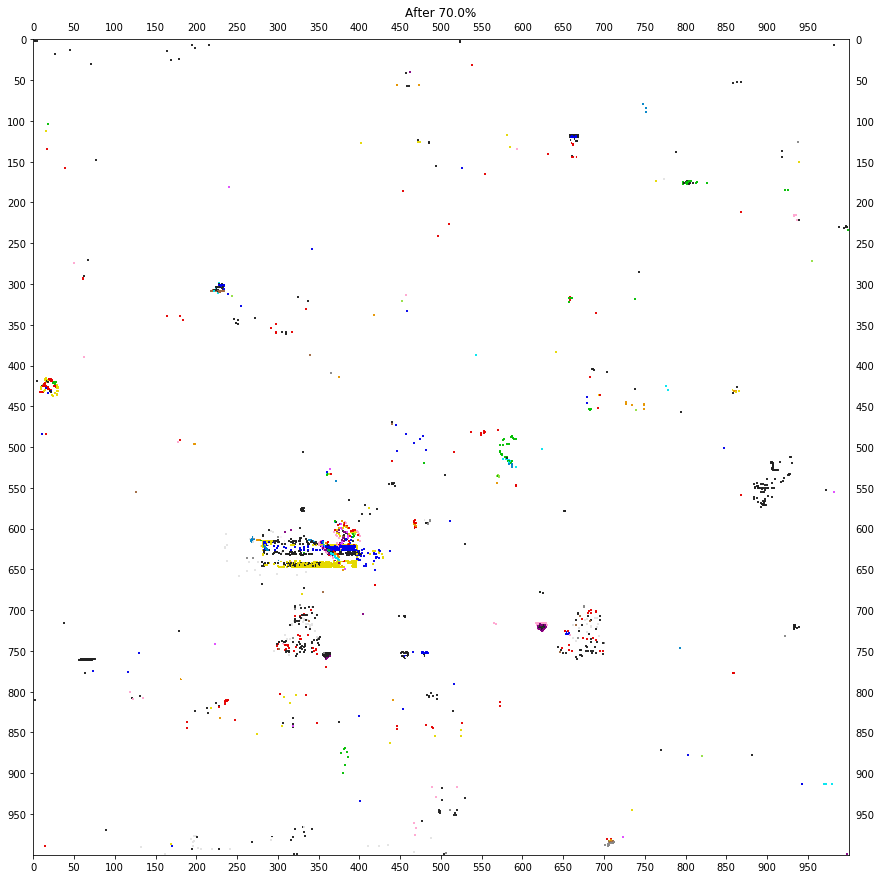

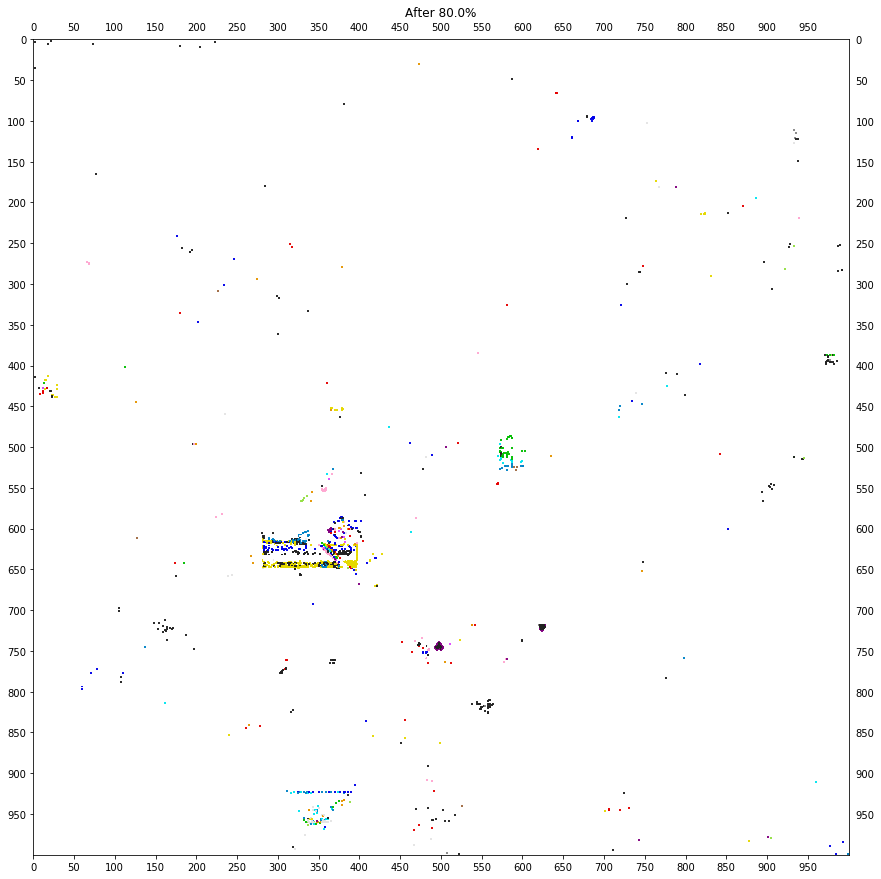

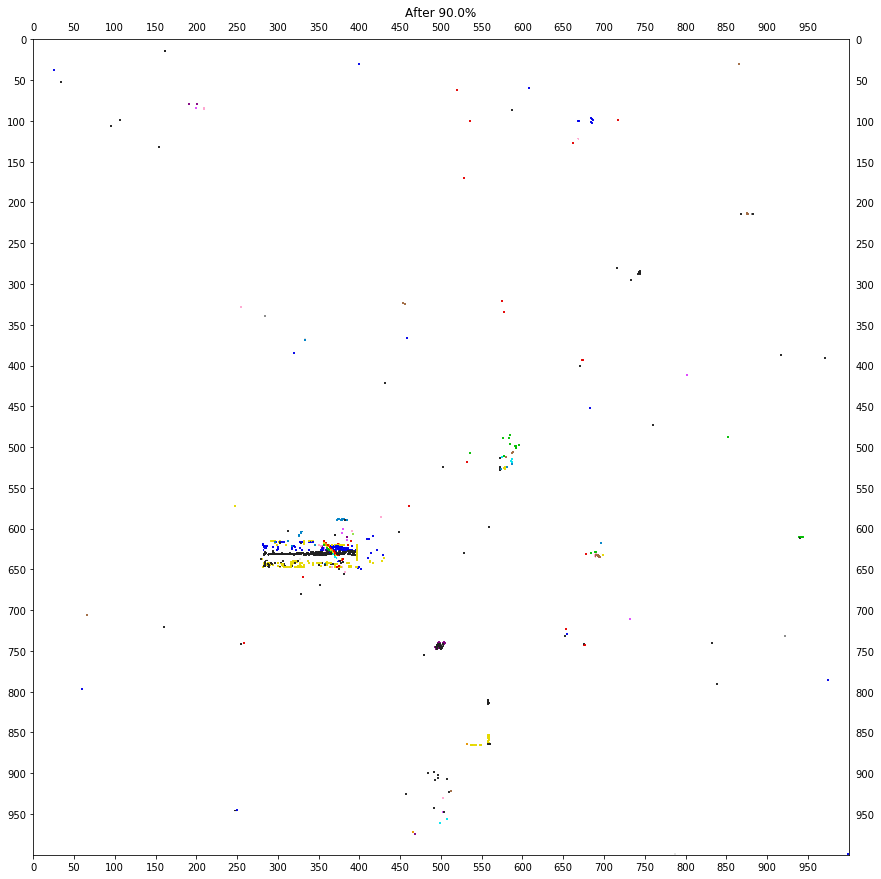

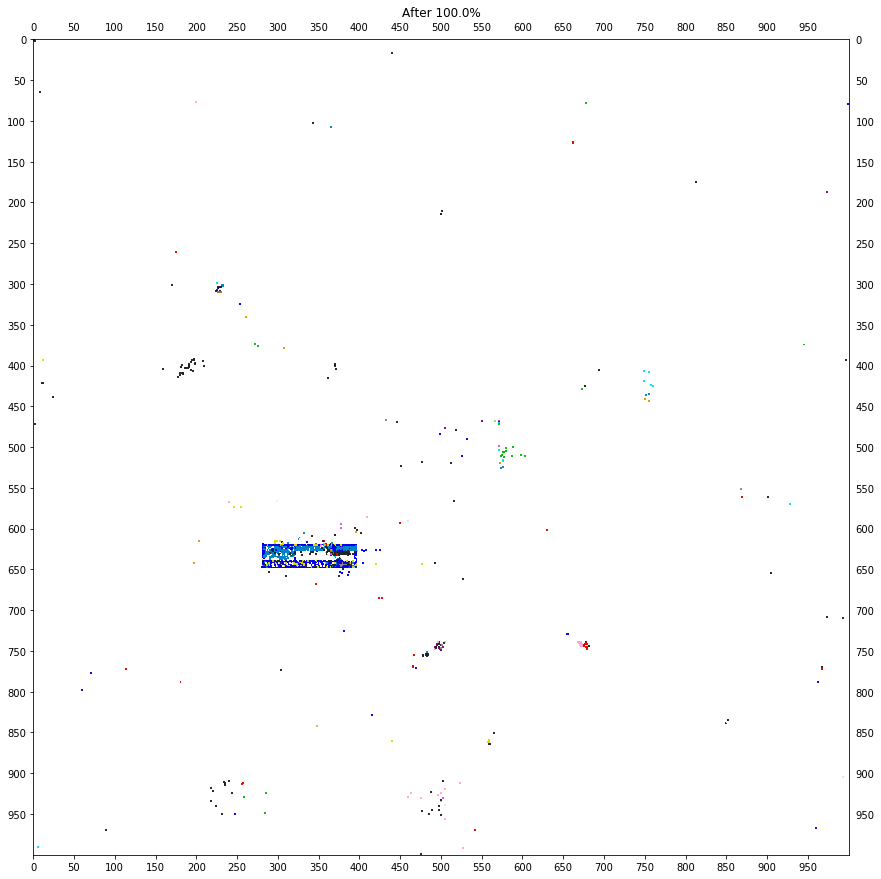

In [19]:
builders = find_flag_builders(0.1, 0.8)
for i in np.arange(0,1,0.1):
    flagusers = find_userset_points(builders, i, i + 0.1)
    display_scatter(flagusers, i)

##### Method to find activity of our builders

In [20]:
def find_activity(users, starttime=0, endtime=1, interval=0.1):
    out = []
    for i in np.arange(starttime, endtime, interval):
        points = find_userset_points(users, i, i+interval)
        out.append(len(points))
    return out

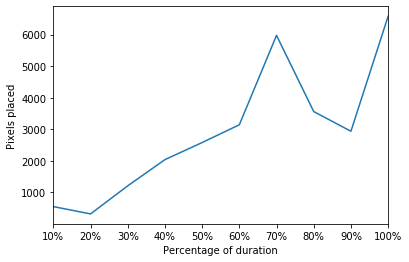

In [21]:
plot_activity(find_activity(builders))

##### Here were going to create a plot that shows every unique pixel visited by our Estonians.

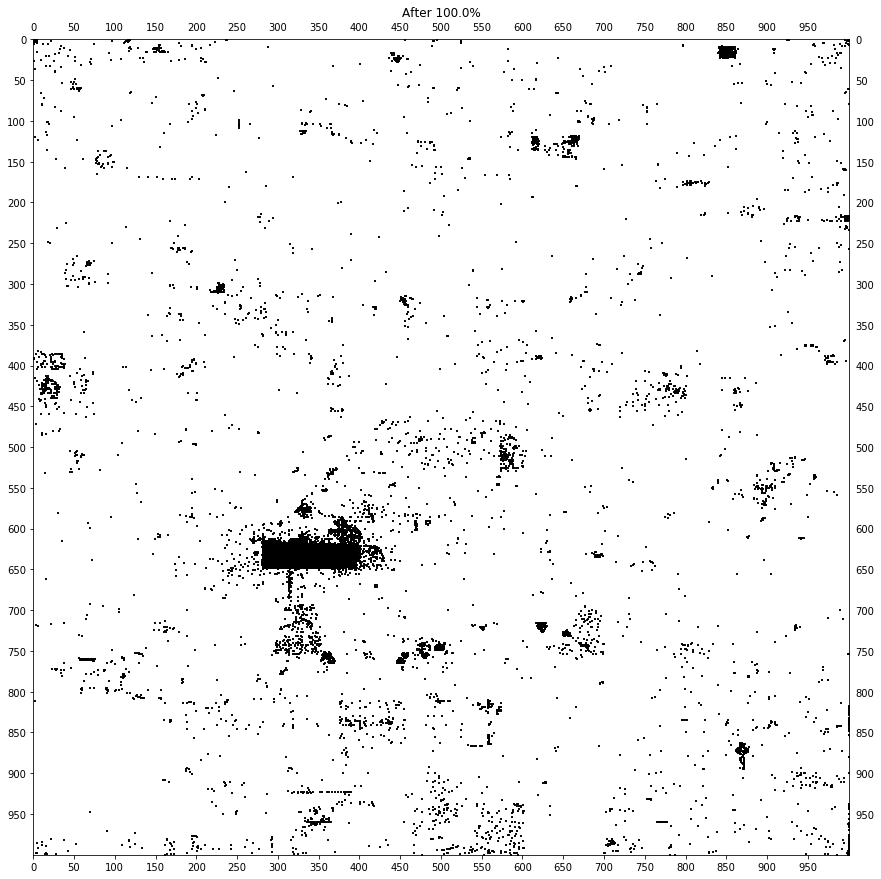

Number of unique pixels placed: 10148
Percent of canvas covered: 0.010148


In [22]:
flagusers = find_userset_points(builders, 0, 1)
display_scatter_decorated(flagusers, i)
print("Number of unique pixels placed:", len(flagusers.groupby(['x','y'])))
print("Percent of canvas covered:", len(flagusers.groupby(['x','y']))/1000000)

## Step 4 ##

##### Let's generate a heatmap of all our found Estonians' activities.

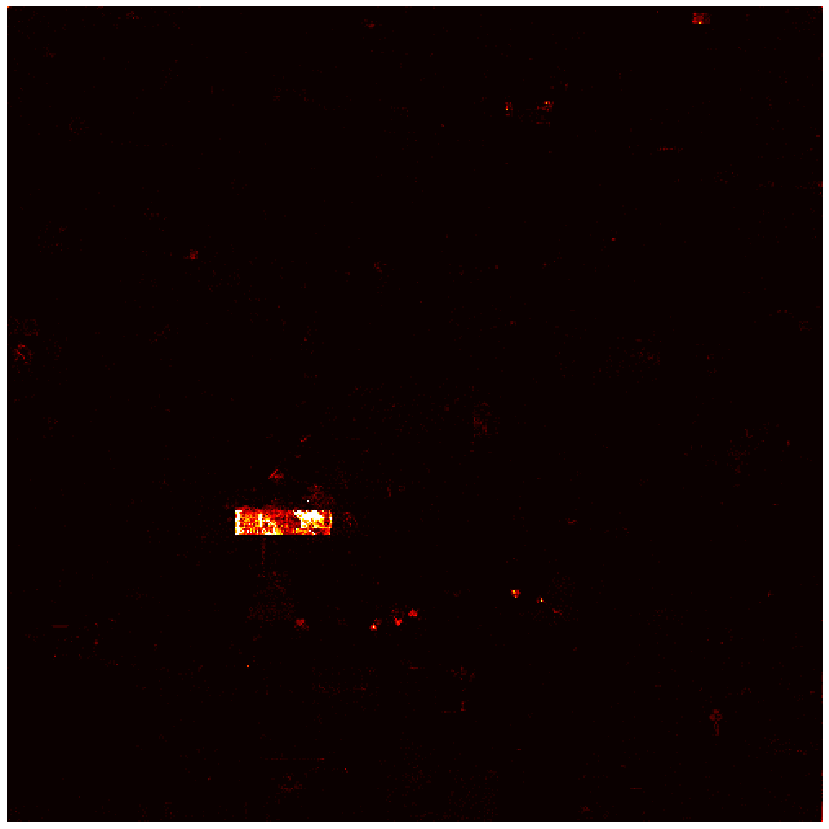

In [23]:
xy = flagusers[['x','y']].to_numpy()
hist,_,_ = np.histogram2d(xy[:,1], xy[:,0], bins=(500,500))
fig = plt.figure(figsize=(15,15))
plt.imshow(hist,cmap='hot', vmax=35)
plt.axis('off')
#plt.savefig('images/heatmap.png')
plt.show()

## Step 5 ##

And now we shall use that scatterplots found earlier and check out some areas of interest. Hopefully we'll find what our Estonians did.

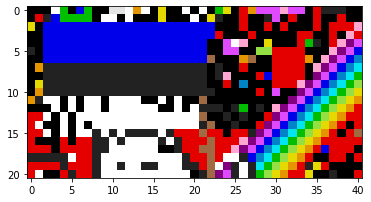

In [24]:
img = canvas_region(839,6,839+40,6+20,0.4)
plt.figure()
imgplot = plt.imshow(img)

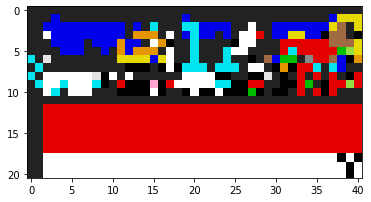

In [25]:
img = canvas_region(610,117,610+40,117+20,0.5)
plt.figure()
imgplot = plt.imshow(img)

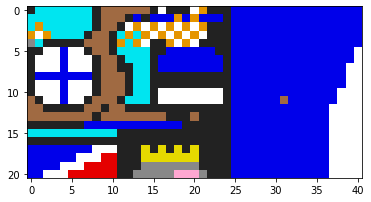

In [26]:
img = canvas_region(210,295,210+40,295+20,0.7)
plt.figure()
imgplot = plt.imshow(img)

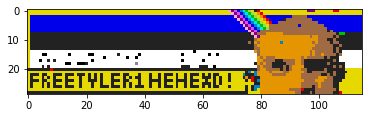

In [27]:
img = canvas_region(281,619,395,647,0.84)
plt.figure()
imgplot = plt.imshow(img)

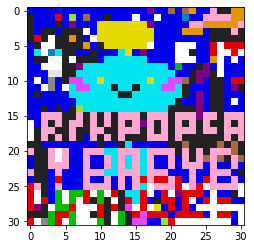

In [28]:
img = canvas_region(855,860,855+30,860+30,0.6)
plt.figure()
imgplot = plt.imshow(img)

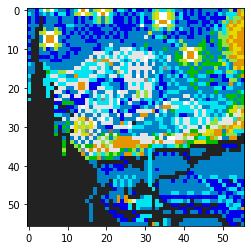

In [29]:
img = canvas_region(325,925,325+55,925+55,0.8)
plt.figure()
imgplot = plt.imshow(img)

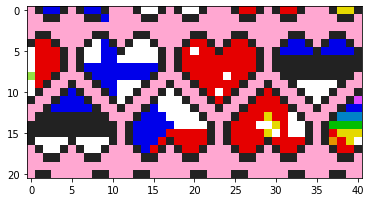

In [30]:
img = canvas_region(444,747,444+40,747+20,0.465)
plt.figure()
imgplot = plt.imshow(img)

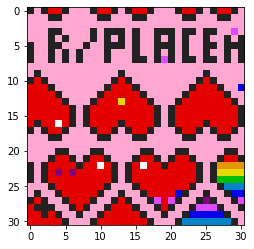

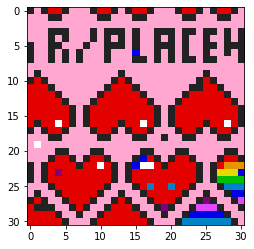

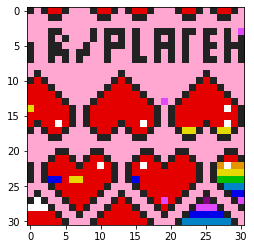

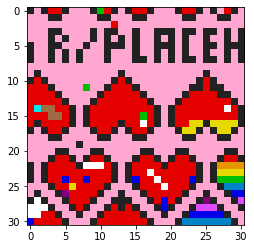

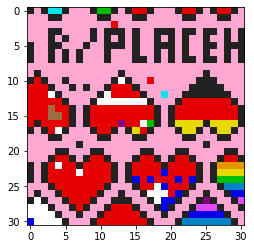

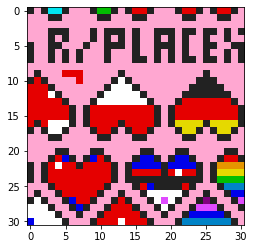

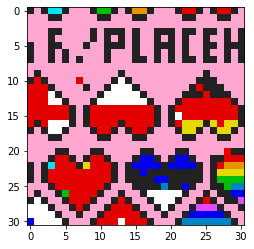

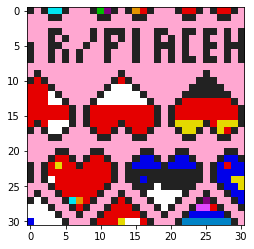

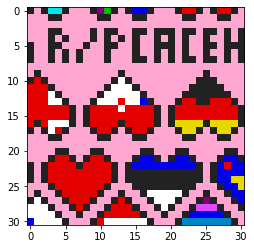

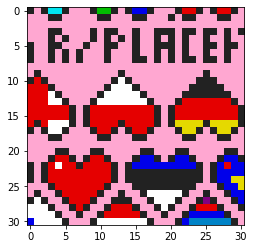

In [31]:
for i in np.arange(0.4,0.5,0.01):
    img = canvas_region(460,730,460+30,730+30,i)
    plt.figure()
    imgplot = plt.imshow(img)